In [1]:
import sys
# TODO: clean this up
sys.path.insert(0, "/Users/danieldubovski/projects/deep_query_optimization/")

In [2]:
from dqo.datasets import QueriesDataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from dqo.relational import SQLParser
import scipy.stats
from collections import Counter

In [3]:
ds_imdb = QueriesDataset("imdb:optimized")
ds_tpch = QueriesDataset("tpch:optimized")
ds_tpcds = QueriesDataset("tpcds:optimized")
ds_tpcd = QueriesDataset("tpcd:optimized")

In [4]:
df_imdb = ds_imdb.load()
df_tpch = ds_tpch.load()
df_tpcds = ds_tpcds.load()
df_tpcd = ds_tpcd.load()

2021-01-25 13:09:18,510 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/optimized/runtimes/data_part_00.csv [1/1]
2021-01-25 13:09:19,359 | dqo.datasets | INFO | Loaded 27512 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/optimized/runtimes/data_part_00.csv [1/1]
2021-01-25 13:09:19,362 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/optimized/runtimes/data_part_00.csv [1/1]
2021-01-25 13:09:19,793 | dqo.datasets | INFO | Loaded 22729 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/optimized/runtimes/data_part_00.csv [1/1]
2021-01-25 13:09:19,795 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpcds/execution/optimized/runtimes/data_part_00.csv [1/1]
2021-01-25 13:09:20,309 | dqo.data

In [5]:
df_imdb.runtime.describe(), df_tpch.describe(), df_tpcds.describe(), df_tpcd.describe()

(count    27512.000000
 mean         3.110239
 std         14.658474
 min          0.100008
 25%          0.620929
 50%          1.083305
 75%          1.848192
 max        328.635661
 Name: runtime, dtype: float64,
             runtime
 count  22729.000000
 mean       8.111727
 std       24.242878
 min        0.100030
 25%        0.405670
 50%        0.612942
 75%        2.452900
 max      427.112079,
             runtime
 count  14676.000000
 mean      16.747197
 std       37.118778
 min        0.100144
 25%        2.802534
 50%        5.948664
 75%       13.322825
 max      492.811580,
             runtime
 count  23635.000000
 mean       8.435864
 std       28.895102
 min        0.100063
 25%        0.311521
 50%        0.507593
 75%        2.761433
 max      489.971649)

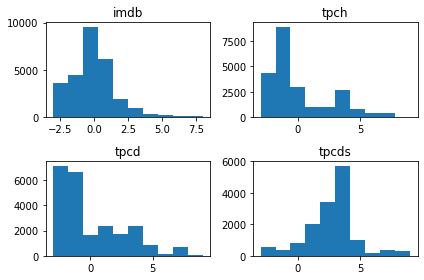

In [6]:
df_imdb['bucket'] = df_imdb.runtime.apply(np.log2).apply(np.round).apply(int)
df_tpch['bucket'] = df_tpch.runtime.apply(np.log2).apply(np.round).apply(int)
df_tpcd['bucket'] = df_tpcd.runtime.apply(np.log2).apply(np.round).apply(int)
df_tpcds['bucket'] = df_tpcds.runtime.apply(np.log2).apply(np.round).apply(int)


fig, ax = plt.subplots(2,2)

ax[0][0].title.set_text('imdb')
ax[0][0].hist(df_imdb['bucket'])

ax[0][1].title.set_text('tpch')
ax[0][1].hist(df_tpch['bucket'])

ax[1][0].title.set_text('tpcd')
ax[1][0].hist(df_tpcd['bucket'])

ax[1][1].title.set_text('tpcds')
ax[1][1].hist(df_tpcds['bucket'])
fig.tight_layout()


## Tree Data

In [7]:
def tree_density(n, h):
    return (n - h)/(2 ** (h + 1) - h - 1)

def calc_query_stat(_df):
    query_stats_df = pd.DataFrame()
    for index, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        query = row['query'].strip()

        try:
            rel_tree = SQLParser.to_relational_tree(query)

            copied = row.copy()
            copied['tree'] = rel_tree
            copied['nodes'] = len(rel_tree)
            copied['relations'] = len(rel_tree.relations)
            copied['projections'] = len(rel_tree.get_projections())
            copied['selections'] = len(rel_tree.get_selections(include_joins=False))
            copied['joins'] = len(rel_tree.get_joins())
            copied['depth'] = rel_tree.depth()
            copied['density'] = tree_density(copied['nodes'], copied['depth'])
            query_stats_df = query_stats_df.append(copied)
        except Exception as e:
            print(e)
            break
        
    return query_stats_df

In [8]:
imdb_query_stats = calc_query_stat(df_imdb)

In [9]:
tpch_query_stats = calc_query_stat(df_tpch)

In [10]:
tpcds_query_stats = calc_query_stat(df_tpcds)

In [11]:
tpcd_query_stats = calc_query_stat(df_tpcd)

# Relationalimdb_schema = ds_imdb.schema()

In [ ]:
imdb_schema = ds_imdb.schema()

In [51]:
for i,r in tqdm(imdb_query_stats.iterrows(), total=len(imdb_query_stats)):
    numbers = False
    strings = False
    for n in r['tree'].nodes():
        t = str(type(n).__name__)
        if t in ['JoinNode','SelectionNode']:
            for operand in n.operands:
                if type(operand).__name__ == 'RelationColumn':
                    col = imdb_schema[operand.relation.name][operand.column]
                    if col.data_type.value in ['number','float']:
                        numbers = True
                    elif col.data_type.value == 'string':
                        strings = True
    imdb_query_stats.loc[i, 'only_strings'] = strings and not numbers
    imdb_query_stats.loc[i, 'only_numbers'] = numbers and not strings
    imdb_query_stats.loc[i, 'mixed'] = numbers and strings

In [56]:
only_strings = imdb_query_stats.query('only_strings == True')
only_numbers = imdb_query_stats.query('only_numbers == True')

<AxesSubplot:>

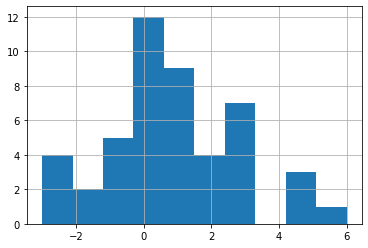

In [59]:
only_strings.runtime.apply(np.log2).apply(np.round).apply(int).hist()

In [61]:
ds = QueriesDataset('imdb:only_strings')
ds.df = only_strings
ds.save(schema=imdb_schema)

<AxesSubplot:>

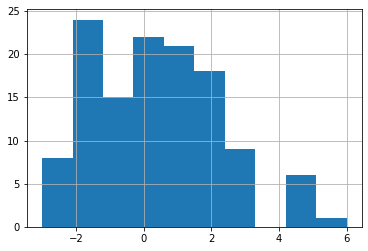

In [60]:
only_numbers.runtime.apply(np.log2).apply(np.round).apply(int).hist()

In [62]:
ds = QueriesDataset('imdb:only_numbers')
ds.df = only_numbers
ds.save(schema=imdb_schema)

# TPCD

In [65]:
tpcd_schema = ds_tpcd.schema()

In [66]:
for i,r in tqdm(tpcd_query_stats.iterrows(), total=len(tpcd_query_stats)):
    numbers = False
    strings = False
    for n in r['tree'].nodes():
        t = str(type(n).__name__)
        if t in ['JoinNode','SelectionNode']:
            for operand in n.operands:
                if type(operand).__name__ == 'RelationColumn':
                    col = tpcd_schema[operand.relation.name][operand.column]
                    if col.data_type.value in ['number','float']:
                        numbers = True
                    elif col.data_type.value == 'string':
                        strings = True
    tpcd_query_stats.loc[i, 'only_strings'] = strings and not numbers
    tpcd_query_stats.loc[i, 'only_numbers'] = numbers and not strings
    tpcd_query_stats.loc[i, 'mixed'] = numbers and strings

In [67]:
tpcd_only_strings = tpcd_query_stats.query('only_strings == True')
tpcd_only_numbers = tpcd_query_stats.query('only_numbers == True')

<AxesSubplot:>

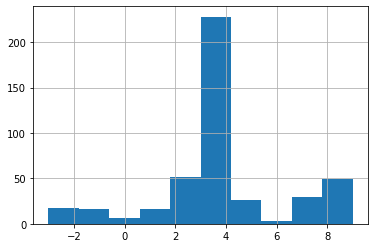

In [68]:
tpcd_only_strings.runtime.apply(np.log2).apply(np.round).apply(int).hist()

<AxesSubplot:>

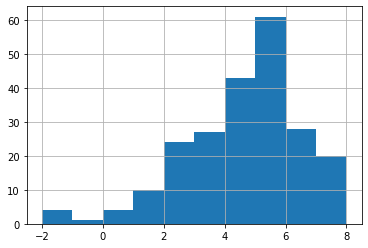

In [69]:
tpcd_only_numbers.runtime.apply(np.log2).apply(np.round).apply(int).hist()

In [70]:
ds = QueriesDataset('tpcd:only_strings')
ds.df = tpcd_only_strings
ds.save(schema=tpcd_schema)
ds = QueriesDataset('tpcd:only_numbers')
ds.df = tpcd_only_numbers
ds.save(schema=tpcd_schema)

# DEPTH & NODES

In [17]:
imdb_query_stats.depth.describe(), tpch_query_stats.depth.describe(), tpcds_query_stats.depth.describe(), tpcd_query_stats.depth.describe()

(count    27512.000000
 mean        50.469613
 std         32.094459
 min          1.000000
 25%         20.000000
 50%         47.000000
 75%         78.000000
 max        117.000000
 Name: depth, dtype: float64,
 count    22729.000000
 mean        38.931893
 std         32.005278
 min          1.000000
 25%         12.000000
 50%         28.000000
 75%         60.000000
 max        116.000000
 Name: depth, dtype: float64,
 count    14676.000000
 mean        39.059349
 std         26.090765
 min          1.000000
 25%         18.000000
 50%         31.000000
 75%         56.000000
 max        124.000000
 Name: depth, dtype: float64,
 count    23635.000000
 mean        40.912968
 std         31.007642
 min          1.000000
 25%         14.000000
 50%         34.000000
 75%         60.000000
 max        116.000000
 Name: depth, dtype: float64)

In [36]:
len(tpcd_query_stats.query('nodes < 125'))

5075

In [37]:
# import os
# ds_tpcd.df.to_csv(os.path.join(ds_tpcd.input_path, 'part_00.csv'), header=False, index=False, columns=['query', 'runtime'])

array([[<AxesSubplot:title={'center':'bucket'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'depth'}>],
       [<AxesSubplot:title={'center':'joins'}>,
        <AxesSubplot:title={'center':'nodes'}>,
        <AxesSubplot:title={'center':'projections'}>],
       [<AxesSubplot:title={'center':'relations'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'selections'}>]], dtype=object)

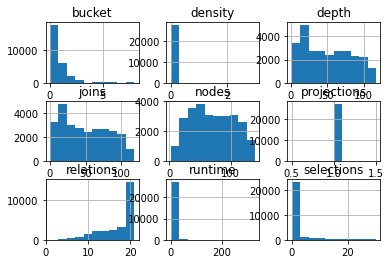

In [38]:
imdb_query_stats.hist()

array([[<AxesSubplot:title={'center':'bucket'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'depth'}>],
       [<AxesSubplot:title={'center':'joins'}>,
        <AxesSubplot:title={'center':'nodes'}>,
        <AxesSubplot:title={'center':'projections'}>],
       [<AxesSubplot:title={'center':'relations'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'selections'}>]], dtype=object)

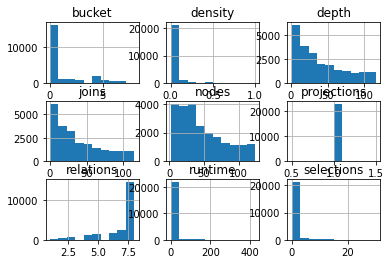

In [39]:
tpch_query_stats.hist()

array([[<AxesSubplot:title={'center':'bucket'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'depth'}>],
       [<AxesSubplot:title={'center':'joins'}>,
        <AxesSubplot:title={'center':'nodes'}>,
        <AxesSubplot:title={'center':'projections'}>],
       [<AxesSubplot:title={'center':'relations'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'selections'}>]], dtype=object)

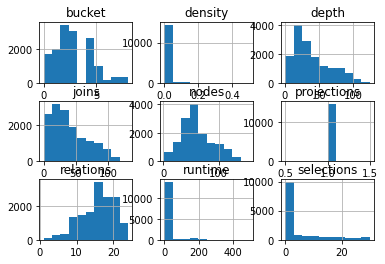

In [40]:
tpcds_query_stats.hist()

array([[<AxesSubplot:title={'center':'bucket'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'depth'}>],
       [<AxesSubplot:title={'center':'joins'}>,
        <AxesSubplot:title={'center':'nodes'}>,
        <AxesSubplot:title={'center':'projections'}>],
       [<AxesSubplot:title={'center':'relations'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'selections'}>]], dtype=object)

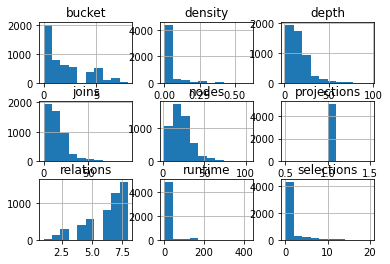

In [41]:
tpcd_query_stats.hist()

## Density

<AxesSubplot:title={'center':'tpcd'}>

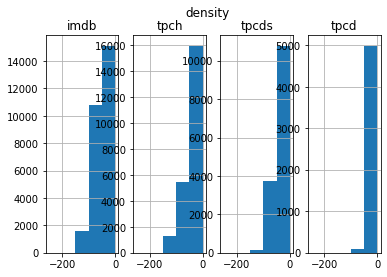

In [43]:
fig, axes = plt.subplots(1, 4)
bins = [-250,-200,-150,-100, -50, 0]

fig.suptitle("density")
axes[0].title.set_text('imdb')
axes[1].title.set_text('tpch')
axes[2].title.set_text('tpcds')
axes[3].title.set_text('tpcd')


imdb_query_stats.density.apply(np.log2).hist(bins=bins,ax=axes[0])
tpch_query_stats.density.apply(np.log2).hist(bins=bins, ax=axes[1])
tpcds_query_stats.density.apply(np.log2).hist(bins=bins, ax=axes[2])
tpcd_query_stats.density.apply(np.log2).hist(bins=bins, ax=axes[3])

## Depth

<AxesSubplot:title={'center':'tpcd'}>

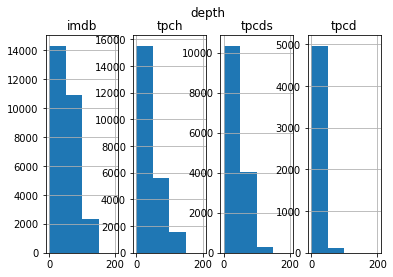

In [44]:
fig, axes = plt.subplots(1, 4)
bins = [0, 50, 100, 150, 200]

fig.suptitle("depth")
axes[0].title.set_text('imdb')
axes[1].title.set_text('tpch')
axes[2].title.set_text('tpcds')
axes[3].title.set_text('tpcd')

imdb_query_stats.depth.hist(bins=bins,ax=axes[0])
tpch_query_stats.depth.hist(bins=bins, ax=axes[1])
tpcds_query_stats.depth.hist(bins=bins, ax=axes[2])
tpcd_query_stats.depth.hist(bins=bins, ax=axes[3])

## Nodes


<AxesSubplot:title={'center':'tpcd'}>

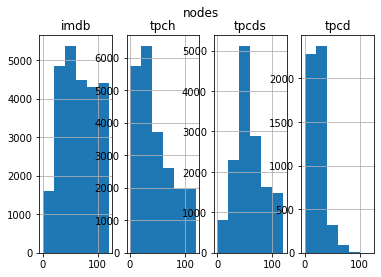

In [46]:
fig, axes = plt.subplots(1, 4)
bins = [0, 20, 40, 60, 80, 100, 120]

fig.suptitle("nodes")
axes[0].title.set_text('imdb')
axes[1].title.set_text('tpch')
axes[2].title.set_text('tpcds')
axes[3].title.set_text('tpcd')

imdb_query_stats.nodes.hist(bins=bins,ax=axes[0])
tpch_query_stats.nodes.hist(bins=bins, ax=axes[1])
tpcds_query_stats.nodes.hist(bins=bins, ax=axes[2])
tpcd_query_stats.nodes.hist(bins=bins, ax=axes[3])

---

# Dataset Stats

In [71]:
imdb_schema = ds_imdb.schema()
tpch_schema = ds_tpch.schema()
tpcds_schema = ds_tpcds.schema()
tpcd_schema = ds_tpcs.schema()

In [138]:
def describe_schema(s):
    stats = {}
    
    stats['tables'] = len(s.tables)
    stats['columns'] = len(s.columns)
    
    dtypes = []
    rows = []
    distincts = []
    nulls = []
    cols_per_table = []
    table_size = []
    
    for t in s.tables:
        cols_per_table.append(len(t.columns))
        for i, col in enumerate(t.columns):
            if i == 0:
                rows.append(col.stats.total)
                table_size.append(col.stats.total * len(t.columns))
            
            distincts.append(col.stats.distinct / col.stats.total)
            nulls.append(col.stats.nulls / col.stats.total)
            dtypes.append(str(col.data_type))
    c = Counter(dtypes)
    stats['dtypes'] = [(v, f'{c[v] / len(dtypes) * 100.0:.2f}%', c[v]) for v in c]
    stats['rows'] = np.histogram(np.log10(np.array(rows)), bins=5)
    stats['distincts'] = scipy.stats.describe(np.array(distincts))
    stats['nulls'] = scipy.stats.describe(np.array(nulls))
    stats['cols_per_table'] = np.histogram((np.array(cols_per_table)), bins=5)
    stats['table_size'] = np.histogram(np.log10(np.array(table_size)), bins=5)
    
    return stats
from pprint import pprint
print('imdb: \n')
pprint(describe_schema(imdb_schema))
print('')
print('tpch: \n')
pprint(describe_schema(tpch_schema))
print('')
print('tpcds: \n')
pprint(describe_schema(tpcds_schema))

imdb: 

{'cols_per_table': (array([8, 6, 3, 2, 2]),
                    array([ 2.,  4.,  6.,  8., 10., 12.])),
 'columns': 108,
 'distincts': DescribeResult(nobs=108, minmax=(0.0, 1.0), mean=0.4143007662470856, variance=0.2074871588778503, skewness=0.3766570715988044, kurtosis=-1.7483771943052444),
 'dtypes': [('DataType.NUMBER', '54.63%', 59),
            ('DataType.STRING', '45.37%', 49)],
 'nulls': DescribeResult(nobs=108, minmax=(0.0, 1.0), mean=0.19641912711343756, variance=0.12737557397561525, skewness=1.5327831580385185, kurtosis=0.6401177469580346),
 'rows': (array([5, 1, 1, 6, 8]),
          array([0.60205999, 1.99349604, 3.38493209, 4.77636814, 6.16780419,
       7.55924024])),
 'table_size': (array([6, 0, 1, 6, 8]),
                array([0.90308999, 2.40333965, 3.90358931, 5.40383897, 6.90408862,
       8.40433828])),
 'tables': 21}

tpch: 

{'cols_per_table': (array([3, 2, 2, 0, 1]),
                    array([ 3. ,  5.6,  8.2, 10.8, 13.4, 16. ])),
 'columns': 61,
 'disti

## Relational Data

In [ ]:
def describe_relational(_df):
    stats = {}
    
    stats['tables'] = len(s.tables)
    stats['columns'] = len(s.columns)
    
    dtypes = []
    rows = []
    distincts = []
    nulls = []
    cols_per_table = []
    table_size = []
    
    for t in s.tables:
        cols_per_table.append(len(t.columns))
        for i, col in enumerate(t.columns):
            if i == 0:
                rows.append(col.stats.total)
                table_size.append(col.stats.total * len(t.columns))
            
            distincts.append(col.stats.distinct / col.stats.total)
            nulls.append(col.stats.nulls / col.stats.total)
            dtypes.append(str(col.data_type))
    c = Counter(dtypes)
    stats['dtypes'] = [(v, f'{c[v] / len(dtypes) * 100.0:.2f}%', c[v]) for v in c]
    stats['rows'] = np.histogram(np.log10(np.array(rows)), bins=5)
    stats['distincts'] = scipy.stats.describe(np.array(distincts))
    stats['nulls'] = scipy.stats.describe(np.array(nulls))
    stats['cols_per_table'] = np.histogram((np.array(cols_per_table)), bins=5)
    stats['table_size'] = np.histogram(np.log10(np.array(table_size)), bins=5)
    
    return stats
from pprint import pprint
print('imdb: \n')
pprint(describe_schema(imdb_df))
print('')
print('tpch: \n')
pprint(describe_schema(tpch_df))
print('')
print('tpcds: \n')
pprint(describe_schema(tpcds_df))